In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from spcqe.quantiles import SmoothPeriodicQuantiles

In [3]:
def process_excel_file(file_name, year):
    # Check if the year is a leap year
    is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Define the start and end of your time range
    start = pd.Timestamp(f'{year}-01-01 00:00:00')
    end = pd.Timestamp(f'{year}-12-31 23:00:00')
    
    # Create an hourly time index between start and end
    time_index = pd.date_range(start, end, freq='H')
    
    # Read the Excel file and select columns
    df = pd.read_excel(file_name, sheet_name='RI', usecols=['RT_Demand', 'Dry_Bulb', 'RT_LMP'])
    
    # Assign your new time index to your dataframe
    df.index = time_index
    
    return df

years = [2019, 2020, 2021, 2022]
paths = [Path() / 'fixtures' / f'{year}_smd_hourly.xlsx' for year in years]
df_list = [process_excel_file(path, year) for (path, year) in zip(paths, years)]

df = pd.concat(df_list[:-1])
df_test = df_list[-1]
df

,RT_Demand,RT_LMP,Dry_Bulb
2019-01-01 00:00:00,723.322,35.90,42
2019-01-01 01:00:00,688.771,38.81,44
2019-01-01 02:00:00,660.226,21.32,44
2019-01-01 03:00:00,642.773,18.52,46
2019-01-01 04:00:00,638.376,7.57,49
...,...,...,...
2021-12-31 19:00:00,910.589,33.46,44
2021-12-31 20:00:00,866.773,30.89,44
2021-12-31 21:00:00,826.486,30.99,45
2021-12-31 22:00:00,780.592,30.91,45


In [132]:
y1 = df['RT_Demand']
P1 = int(365*24)
P2 = int(7*24)
P3 = int(24)
K = [4, 4, 5]
l = 10
q = (.01, 0.05, .10, .20, .30, .40, .50, .60, .70, .80, .90, 0.95, .99)
spq = SmoothPeriodicQuantiles(K, [P1, P2, P3], weight=l, solver='MOSEK', verbose=True)
spq

SmoothPeriodicQuantiles(num_harmonics=[4, 4, 5], periods=[8760, 168, 24],
                        quantiles=array([0.02, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.98]),
                        solver='MOSEK', verbose=True, weight=10)

In [133]:
spq.fit(y1)
print(f"total time: {spq.fit_time:.2f} seconds")

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 08 02:01:18 PM: Your problem has 2772 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 08 02:01:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 08 02:01:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 08 02:01:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 08 02:01:18 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Sep 08 02:01:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [83]:
spq.fit(y1)
print(f"total time: {spq.fit_time:.2f} seconds")

100%|███████████████████████████████████████████| 13/13 [02:36<00:00, 12.04s/it]


total time: 156.80 seconds


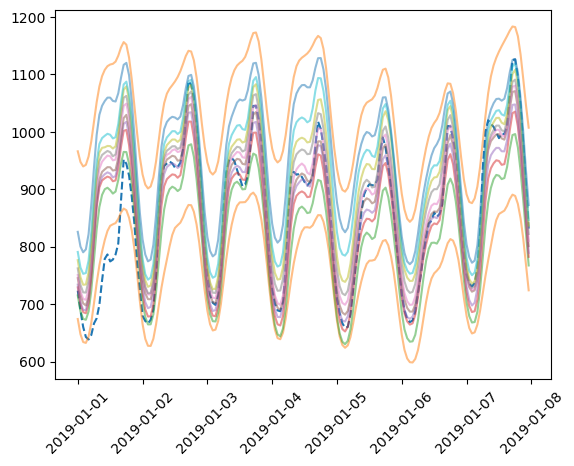

In [134]:
ix = 0
slc = np.s_[24 * ix:24 * (ix + 7)]
xs = df.index[slc]
plt.plot(xs, y1[slc], ls='--')
plt.plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

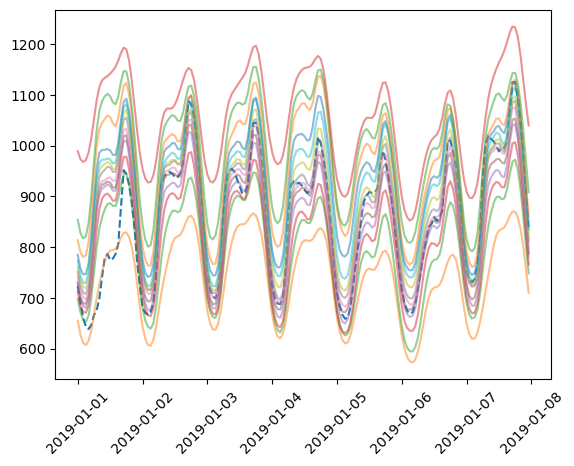

In [85]:
ix = 0
slc = np.s_[24 * ix:24 * (ix + 7)]
xs = df.index[slc]
plt.plot(xs, y1[slc], ls='--')
plt.plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

# Predict quantile for new time periods, not used in training

In [135]:
q_predict = spq.predict(np.arange(365*24)+365*24*3)
q_predict.shape

(8760, 11)

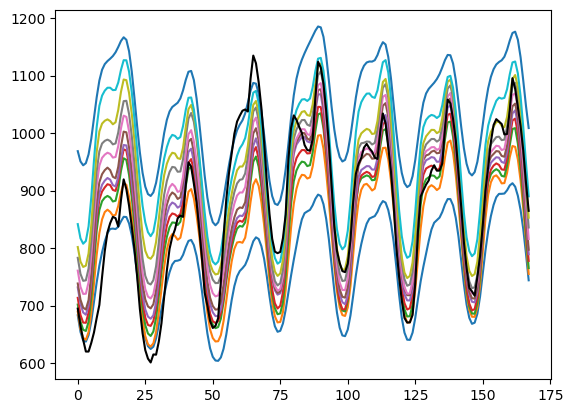

In [136]:
plt.plot(q_predict[slc, :])
plt.plot(df_test["RT_Demand"].iloc[slc].values, color='black');

# use fit quantiles to transform the data to be Gaussian

In [137]:
x1 = spq.transform(y1)

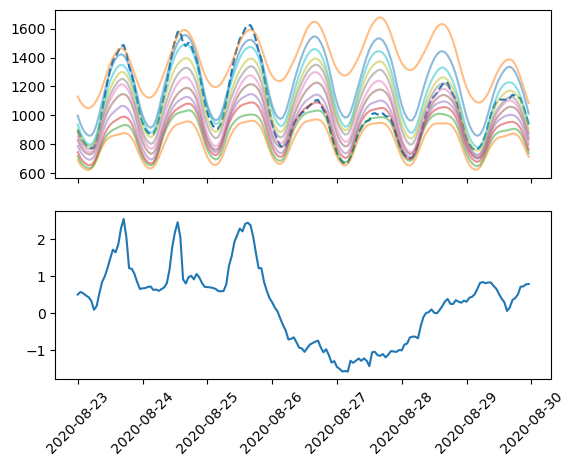

In [138]:
ix = 600
slc = np.s_[24 * ix:24 * (ix + 7)]
xs = df.index[slc]
fig, ax = plt.subplots(nrows=2, sharex=True);
ax[0].plot(xs, y1[slc], ls='--')
ax[0].plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
ax[1].plot(xs, x1[slc])
plt.xticks(rotation=45);

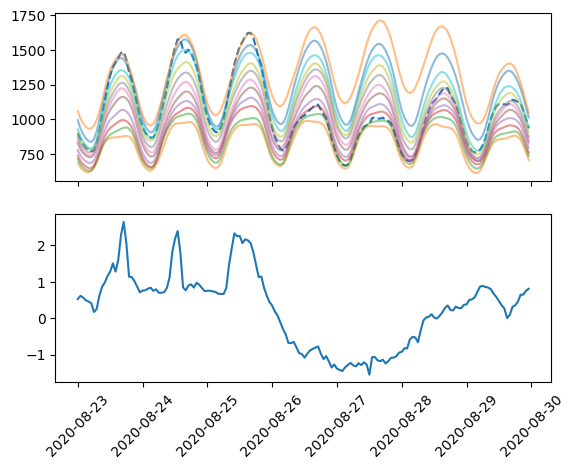

In [69]:
ix = 600
slc = np.s_[24 * ix:24 * (ix + 7)]
xs = df.index[slc]
fig, ax = plt.subplots(nrows=2, sharex=True);
ax[0].plot(xs, y1[slc], ls='--')
ax[0].plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
ax[1].plot(xs, x1[slc])
plt.xticks(rotation=45);

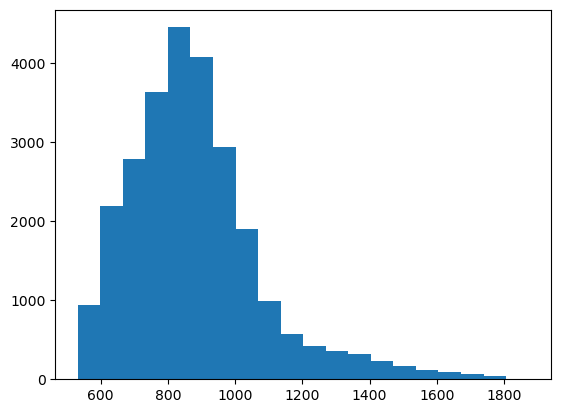

In [139]:
plt.hist(y1, bins=20);

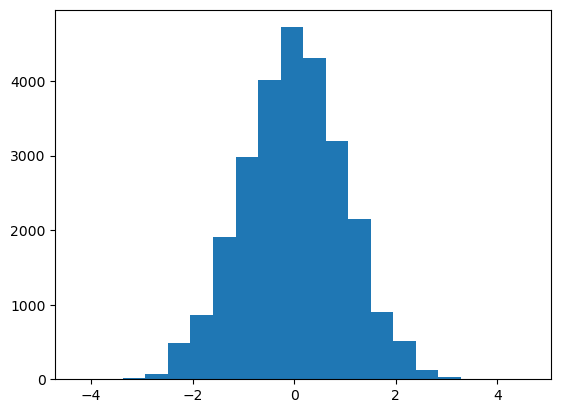

In [140]:
plt.hist(x1[np.abs(x1) < 5], bins=20);

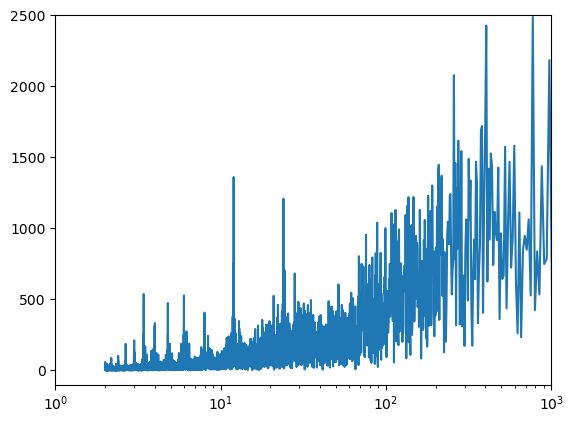

In [175]:
from scipy.fft import fft, fftfreq
xf = fftfreq(len(x1), 60*60)
yf = fft(x1)
xft = (1 / xf[xf>0]) /60/60
plt.plot(xft, np.abs(yf)[xf>0])
plt.xlim(1, 1e3)
plt.ylim(-100, 2500)
plt.xscale('log');

# Use inverse transform to go back to the original data space

In [141]:
y2 = spq.inverse_transform(x1)

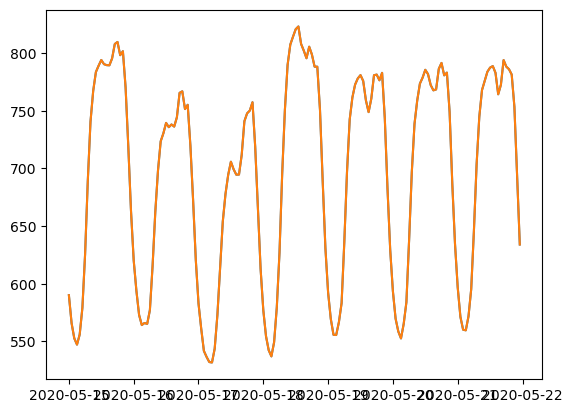

In [142]:
ix = 500
slc = np.s_[24 * ix:24 * (ix + 7)]
xs = df.index[slc]
plt.plot(xs, y1[slc])
plt.plot(xs, y2[slc]);

In [143]:
np.allclose(y1, y2)

True

In [144]:
np.sum(np.abs(x1) > 5) 

6

In [145]:
np.sum(np.abs(x1) > 5) / x1.size

0.0002281021897810219

In [146]:
import scipy.stats as stats
(1 - stats.norm.cdf(5)) * 2

5.733031438470704e-07

In [147]:
ix_outliers = np.arange(len(y1))[np.abs(x1) > 5]
ix_outliers

array([ 522, 2347, 2371, 2372, 2395, 2396])

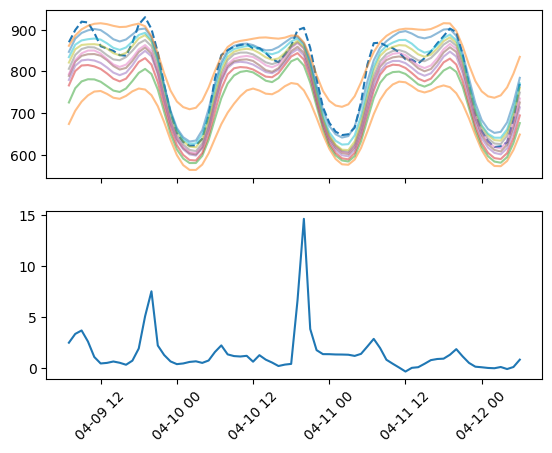

In [148]:
ix = 2395 #ix_outliers[3] #16912
slc = np.s_[int(ix-24*1.5):int(ix+24*1.5)]
xs = df.index[slc]
fig, ax = plt.subplots(nrows=2, sharex=True);
ax[0].plot(xs, y1[slc], ls='--')
ax[0].plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
ax[1].plot(xs, x1[slc])
plt.xticks(rotation=45);

In [80]:
import scipy.stats as stats

Q_left_tail=spq.fit_quantiles[:,0]-1
Q_left_tail=Q_left_tail.reshape(-1,1)
Q_right_tail=spq.fit_quantiles[:,-1]+1
Q_right_tail=Q_right_tail.reshape(-1,1)
Q_extended=np.hstack([Q_left_tail, spq.fit_quantiles, Q_right_tail])

percentiles=spq.quantiles
g=np.zeros((Q_extended.shape[0],len(percentiles)+2))
g[:,1:-1]=stats.norm.ppf(percentiles)

left_tail_slope = (g[:,2] - g[:,1]) / (Q_extended[:,2] - Q_extended[:,1])
right_tail_slope = (g[:,-2] - g[:,-3]) / (Q_extended[:,-2] - Q_extended[:,-3])
g[:,0]=g[:,1]-left_tail_slope
g[:,-1]=g[:,-2]+right_tail_slope
GQ_extended=g

In [10]:
from scipy.interpolate import bisplrep, bisplev
try:
    T = spq.fit_quantiles.shape[0]
    y = np.tile(stats.norm.ppf(percentiles), (T, 1))
    xxr = spq.fit_quantiles.ravel()
    yyr = np.tile(np.arange(T), (len(spq.quantiles), 1)).T.ravel()
    zzr = y.ravel()
    tck = bisplrep(xxr, yyr, zzr, kx=1, ky=1, s=0)
    ff = lambda xnew, ynew: bisplev(xnew, ynew, tck).T
except OverflowError as e:
    print(e, f"\n{len(xxr)} > 10000")

Too many data points to interpolate 
385704 > 10000


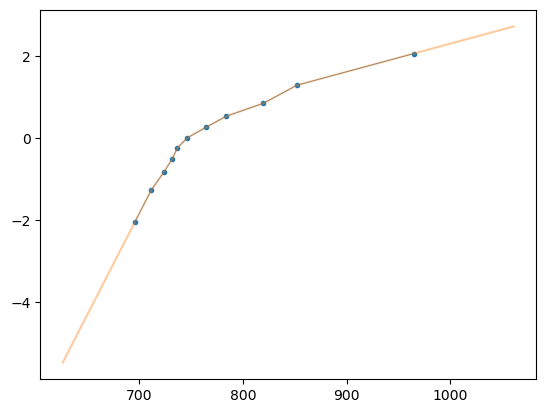

In [11]:
# one time slice
from scipy.interpolate import interp1d

tix = int(307.4 * 96)
x = spq.fit_quantiles[tix]
y = stats.norm.ppf(spq.quantiles)
f = interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate', assume_sorted=True)

plt.plot(x, y, marker='.', linewidth=0.5)
xs = np.linspace(np.min(x)*.9, np.max(x)*1.1, int(1e3))
plt.plot(xs, f(xs), alpha=0.4);

In [12]:
h1 = np.ones(len(x))
h2 = x
h3up = [np.clip(x - kn, 0, np.inf) for kn in x[1:-1]]
basis = np.r_[[h1, h2] + h3up].T
params = np.linalg.solve(basis, y)

In [13]:
def x_expand(xi, tix):
    xin = np.atleast_1d(xi)
    h1 = np.ones_like(xin)
    h2 = xin
    h3up = [np.clip(xin - kn, 0, np.inf) for kn in spq.fit_quantiles[tix][1:-1]]
    basis = np.r_[[h1, h2] + h3up].T
    return basis

In [14]:
x_expand([800, 825, 850], tix).shape

(3, 11)

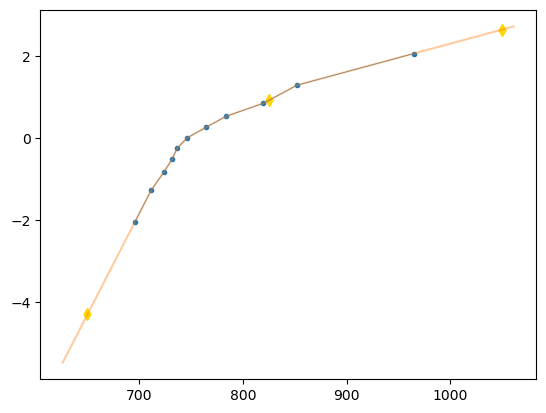

In [15]:
plt.plot(x, y, marker='.', linewidth=0.5)
xs = np.linspace(np.min(x)*.9, np.max(x)*1.1, int(1e3))
plt.plot(xs, f(xs), alpha=0.4)
plt.scatter([650, 825, 1050], x_expand([650, 825, 1050], tix) @ params, marker='d', color='gold');

In [16]:
a = np.random.rand(5, 5, 7, 77)
at = np.moveaxis(a, (0, 1), (2, 3))
print(a.shape, at.shape)

(5, 5, 7, 77) (7, 77, 5, 5)


In [17]:
b = np.random.rand(5)

In [62]:
x_expand(spq.fit_quantiles[tix], tix)

array([[  1.        , 695.8010625 ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  1.        , 711.47619934,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  1.        , 723.67771484,  12.2015155 ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  1.        , 731.64043364,  20.16423429,   7.9627188 ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  1.        , 736.61290267,  25.13670333,  12.93518783,
          4.97246904,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  1.        , 746.43949987,  34.96330052,  22.76178503,
         14.79906623,   9.82659719,   0. 

In [63]:
%time # correct!
mats1 = np.empty((spq.fit_quantiles.shape[0], len(spq.quantiles), len(spq.quantiles)))
for ix in range(spq.fit_quantiles.shape[0]):
    mats1[ix] = x_expand(spq.fit_quantiles[ix], ix)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [19]:
mats.shape

(35064, 11, 11)

In [29]:
%time #correct!
mats2 = np.empty((spq.fit_quantiles.shape[0], len(spq.quantiles), len(spq.quantiles)))
for jx in range(spq.quantiles.shape[0]):
    if jx == 0:
        mats2[:, :, jx] = 1
    elif jx == 1:
        mats2[:, :, jx] = spq.fit_quantiles
    else:
        mats2[:, :, jx] = np.clip(spq.fit_quantiles - np.tile(spq.fit_quantiles[:, jx - 1], (spq.fit_quantiles.shape[1], 1)).T, 0, np.inf)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


In [58]:
mats.shape

(35064, 11, 11)

In [64]:
np.allclose(mats1, mats2)

True

In [46]:
tix = int(307.4 * 96)
np.allclose(basis, mats2[tix])

True

In [48]:
np.allclose(basis, mats1[tix])

False

In [90]:
%time 
yy = stats.norm.ppf(spq.quantiles)[np.newaxis, :]
parameters = np.linalg.solve(mats2, yy)
parameters.shape

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


(35064, 11)

In [55]:
yy.shape

(35064, 11)